 # [Module 1.7] AutoGluon 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 데이터 로딩
- 카테고리 피쳐의 레이블 인코딩
    - 훈련, 테스트 데이터 인코딩 (테스트 데이터의 인코딩시에 훈련에 없는 항목은 'Unknown' 으로 인코딩)
- AutoGluon 데이터 타입으로 변경
- AutoGluon 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

#### AutoGluon Tabular Prediction
- 오토글루온 Tabular 공식 페이지 입니다. 자세한 내용은 아래 링크를 참조 하세요.
    - https://autogluon.mxnet.io/stable/tutorials/tabular_prediction/index.html

## 데이터 세트 로딩
로컬에 저장된 파일을 로딩해서, 다시 한번 Shape(Row, column)을 확인하고 데이터를 확인 합니다.

In [1]:
import pandas as pd

In [2]:
%store -r no_auto_train_file
%store -r no_auto_test_file

In [3]:
train_pd = pd.read_csv(no_auto_train_file)
test_pd = pd.read_csv(no_auto_test_file)

In [4]:
print("auto_train_file: ", train_pd.shape)
print("auto_train_file: ", test_pd.shape)

auto_train_file:  (53740, 18)
auto_train_file:  (13436, 18)


In [5]:
from IPython.display import display as dp
dp(train_pd.head(2))
dp(test_pd.head(2))

,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,12030,taubate,SP,29.99,10.96,9000.0,fashion_shoes,13481,limeira,SP,1,4,10,SP_SP,taubate_limeira,12030_13481,2640.0
1,2,78075,cuiaba,MT,23.90,26.82,1500.0,furniture_decor,17051,bauru,SP,1,4,10,MT_SP,cuiaba_bauru,78075_17051,14625.0


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,0,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


In [6]:
from p_utils import convert_date_type

train_pd = convert_date_type(train_pd, col1='customer_zip_code_prefix')
test_pd = convert_date_type(test_pd, col1='customer_zip_code_prefix')
train_pd = convert_date_type(train_pd, col1='seller_zip_code_prefix')
test_pd = convert_date_type(test_pd, col1='seller_zip_code_prefix')

train_pd.info()

object
object
object
object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53740 entries, 0 to 53739
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   classes                          53740 non-null  int64  
 1   customer_zip_code_prefix         53740 non-null  object 
 2   customer_city                    53740 non-null  object 
 3   customer_state                   53740 non-null  object 
 4   price                            53740 non-null  float64
 5   freight_value                    53740 non-null  float64
 6   product_weight_g                 53740 non-null  float64
 7   product_category_name_english    53740 non-null  object 
 8   seller_zip_code_prefix           53740 non-null  object 
 9   seller_city                      53740 non-null  object 
 10  seller_state                     53740 non-null  object 
 11  order_weekday                    53740 non-null  int

## Category 레이블 Encoding

### Category 변수의 레이블 인코딩 실행

In [7]:
from p_utils import make_test_label_encoding
label_cols = ['customer_city','customer_state','customer_zip_code_prefix',
              'seller_zip_code_prefix','seller_city','seller_state',
              'customer_seller_state','customer_seller_city','customer_seller_zip_code_prefix',
              'product_category_name_english',
             ]
# label_cols = ['customer_city','customer_state']
# label_cols = ['customer_city']
train_pd, test_pd = make_test_label_encoding(train_pd, test_pd, label_cols)

Starting:  customer_city
new col name:  lb_customer_city
Starting:  customer_state
new col name:  lb_customer_state
Starting:  customer_zip_code_prefix
new col name:  lb_customer_zip_code_prefix
Starting:  seller_zip_code_prefix
new col name:  lb_seller_zip_code_prefix
Starting:  seller_city
new col name:  lb_seller_city
Starting:  seller_state
new col name:  lb_seller_state
Starting:  customer_seller_state
new col name:  lb_customer_seller_state
Starting:  customer_seller_city
new col name:  lb_customer_seller_city
Starting:  customer_seller_zip_code_prefix
new col name:  lb_customer_seller_zip_code_prefix
Starting:  product_category_name_english
new col name:  lb_product_category_name_english


### 필요 피쳐만 선택

In [8]:
from p_utils import filter_df

cols = ['classes','price', 'freight_value', 'product_weight_g',
       'product_volume',
       'lb_customer_state', 'lb_customer_city','lb_customer_zip_code_prefix',
       'lb_seller_zip_code_prefix', 'lb_seller_city','lb_seller_state',    
       'lb_customer_seller_state','lb_customer_seller_city','lb_customer_seller_zip_code_prefix' ,   
       'lb_product_category_name_english',
       ]

train_pd = filter_df(train_pd, cols)
test_pd = filter_df(test_pd, cols)


In [9]:
import autogluon.core as ag
# from autogluon.tabular import TabularPrediction as task # 0.0.15 version (dev)
from autogluon import TabularPrediction as task # 0.0.14 version (stable)

## 오토글루온 데이터 타입으로 변경
로컬에 저장된 파일을 오토글로온의 Tabular 데이터 타입으로 로딩 합니다. 이후 랜덤 샘플링을 하고 데이터를 확인 합니다.
- 아래 데이타 샘플을 모두 하면 약 4:30 초 훈련 시간이 걸림

In [10]:
train_data = task.Dataset(df = train_pd)
# subsample_size = train_data.shape[0]
subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head(1))

     classes  price  freight_value  product_weight_g  product_volume  \
588        2  59.99           18.0             525.0          9280.0   

    lb_customer_state lb_customer_city lb_customer_zip_code_prefix  \
588                17             1560                        9699   

    lb_seller_zip_code_prefix lb_seller_city lb_seller_state  \
588                       169            388              20   

    lb_customer_seller_state lb_customer_seller_city  \
588                      204                   10810   

    lb_customer_seller_zip_code_prefix lb_product_category_name_english  
588                              43033                               66  


### 레이블 컬럼 지정
**레이블 컬럼을 지정하여, 오토글루온이 이 컬럼을 레이블로 인식하게 합니다.**

In [11]:
label_column = 'classes'
# print("Summary of class variable: \n", train_data[label_column].describe())

## 오토글루운으로 훈련
- 시간 제약을 2시간으로 합니다. 하지만 아래 훈련은 약 5분 소요 됩니다.
- 훈련 데이터 세트의 사이즈에 따라서 시간은 다양 합니다.
- 하지만 presets를 best_quality 으로 설정하면, 시간은 약 1시간 30분이 소요 됩니다. 하지만 이 경우에는 성능은 다소 올라갑니다. 다른 데이터 세트의 경우는 성능이 올라가는 정도가 다를 수 있습니다. 

In [12]:

%%time
dir = 'adv_agModels-predictClass'  # specifies folder where to store trained models
time_limits = 7200 # seconds
# presets = 'best선_quality'
presets = 'medium_quality_faster_train'

predictor = task.fit(train_data=train_data, label=label_column, 
                     output_directory=dir,
                     time_limits=time_limits,
                     presets=presets)



Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to adv_agModels-predictClass/
AutoGluon Version:  0.0.14
Train Data Rows:    500
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [2, 3, 1, 0, 4]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
	Available Memory:                    70927.94 MB
	Train Data (Original)  Memory Usage: 0.32 MB (0.0% of available memory)
	Inferring data type of each feature based on column v

CPU times: user 2min 55s, sys: 1min 14s, total: 4min 9s
Wall time: 16.6 s


## 테스트 데이터 로딩
- 테스트 데이터를 로딩하여 모델을 평가 합니다.
- 여기서는 y_test의 레이블만 가지고 있는 변수를 생성
- test_data_nolab는 레이블만 없는 피쳐만으로 구성된 데이터를 생성 합니다.

In [13]:
test_data = task.Dataset(df= test_pd)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head(2))

    price  freight_value  product_weight_g  product_volume lb_customer_state  \
0  105.00          23.89            1000.0          7632.0                23   
1   99.97          15.80             650.0          9600.0                25   

  lb_customer_city lb_customer_zip_code_prefix lb_seller_zip_code_prefix  \
0             1372                       10728                       482   
1              784                       11737                       724   

  lb_seller_city lb_seller_state lb_customer_seller_state  \
0            373              14                      271   
1             56               6                      288   

  lb_customer_seller_city lb_customer_seller_zip_code_prefix  \
0                    9397                              51403   
1                    5468                              51403   

  lb_product_category_name_english  
0                               71  
1                               50  


## 모델 예측
- 생성된 모델을 통해서 추론(예측)을 합니다.
- 진실값 (y_test), 예측값(prediction)을 제공하여 accuracy, f1, precision, recall 를 계산 합니다.

In [14]:
# predictor = task.load(dir)  # unnecessary, just demonstrates how to load previously-trained predictor from file

prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.3063411729681453
Evaluations on test data:
{
    "accuracy": 0.3063411729681453,
    "accuracy_score": 0.3063411729681453,
    "balanced_accuracy_score": 0.24992277646289432,
    "matthews_corrcoef": 0.07138772672464229
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.4144144144144144,
        "recall": 0.1348973607038123,
        "f1-score": 0.20353982300884954,
        "support": 1705
    },
    "1": {
        "precision": 0.38682678311499274,
        "recall": 0.25540605478135514,
        "f1-score": 0.3076700434153401,
        "support": 4162
    },
    "2": {
        "precision": 0.3788546255506608,
        "recall": 0.45512679162072767,
        "f1-score": 0.41350295502354,
        "support": 4535
    },
    "3": {
        "precision": 0.18555858310626702,
        "recall": 0.31411439114391143,
        "f1-score": 0.23329907502569375,
        "support": 2168
    },
    "4": {
        "precision": 0.076847290640

Predictions:   [4 2 3 ... 3 1 1]


예측 확률에 대한 predict_proba() 를 확인하기 위해서는 아래를 보세요
- API URL: https://auto.gluon.ai/api/autogluon.task.html#module-autogluon.tabular.tabular_prediction

## 리더 보드 생성
오토글루온에서 사용된 알고리즘의 성능 관련 지표를 확인 합니다. (예: score_test)

In [15]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestClassifierEntr,0.354198,0.27,0.224492,0.113540,0.627521,0.224492,0.113540,0.627521,0,True,5
1,CatboostClassifier,0.353379,0.39,0.044378,0.016313,2.106612,0.044378,0.016313,2.106612,0,True,10
2,LightGBMClassifierXT,0.348467,0.35,0.018551,0.014651,0.218681,0.018551,0.014651,0.218681,0,True,9
3,ExtraTreesClassifierEntr,0.341099,0.27,0.137321,0.113464,0.519782,0.137321,0.113464,0.519782,0,True,7
4,ExtraTreesClassifierGini,0.335219,0.29,0.138536,0.114544,0.523264,0.138536,0.114544,0.523264,0,True,6
5,RandomForestClassifierGini,0.326288,0.22,0.125428,0.114199,0.630214,0.125428,0.114199,0.630214,0,True,4
6,LightGBMClassifier,0.306341,0.40,0.036751,0.014940,0.432567,0.036751,0.014940,0.432567,0,True,8
7,weighted_ensemble_k0_l1,0.306341,0.40,0.039563,0.015585,0.640092,0.002812,0.000645,0.207525,1,True,12
8,LightGBMClassifierCustom,0.282376,0.34,0.019490,0.014711,1.329126,0.019490,0.014711,1.329126,0,True,11
9,KNeighborsClassifierUnif,0.264588,0.25,0.110684,0.109517,0.003461,0.110684,0.109517,0.003461,0,True,2


## 모델 평가 및 Confusion 매트릭스
- SKLearn으로 accuracy, f1 score를 계산 합니다. 오토글루온의 수치와 동일한 결과가 나옵니다.
- Confusion 매트릭스 를 통해서 어느 레이블에서 잘 예측을 했는지를 확인 합니다.

In [16]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.31%
f1_score: 0.25%


[[ 230  904  351  184   36]
 [ 190 1063 1544 1081  284]
 [  86  511 2064 1449  425]
 [  39  198 1058  681  192]
 [  10   72  431  275   78]]


<Figure size 432x288 with 0 Axes>

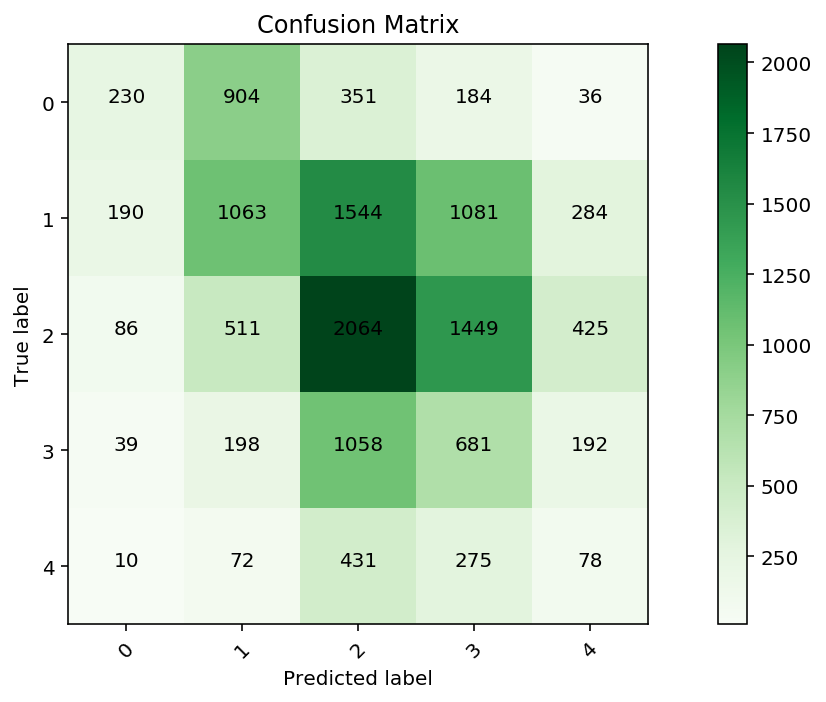

In [17]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance
- 피쳐의 중요도를 확인 합니다.

Computing raw permutation importance for 14 features on weighted_ensemble_k0_l1 ...
	0.7s	= Expected runtime
	0.68s	= Actual runtime


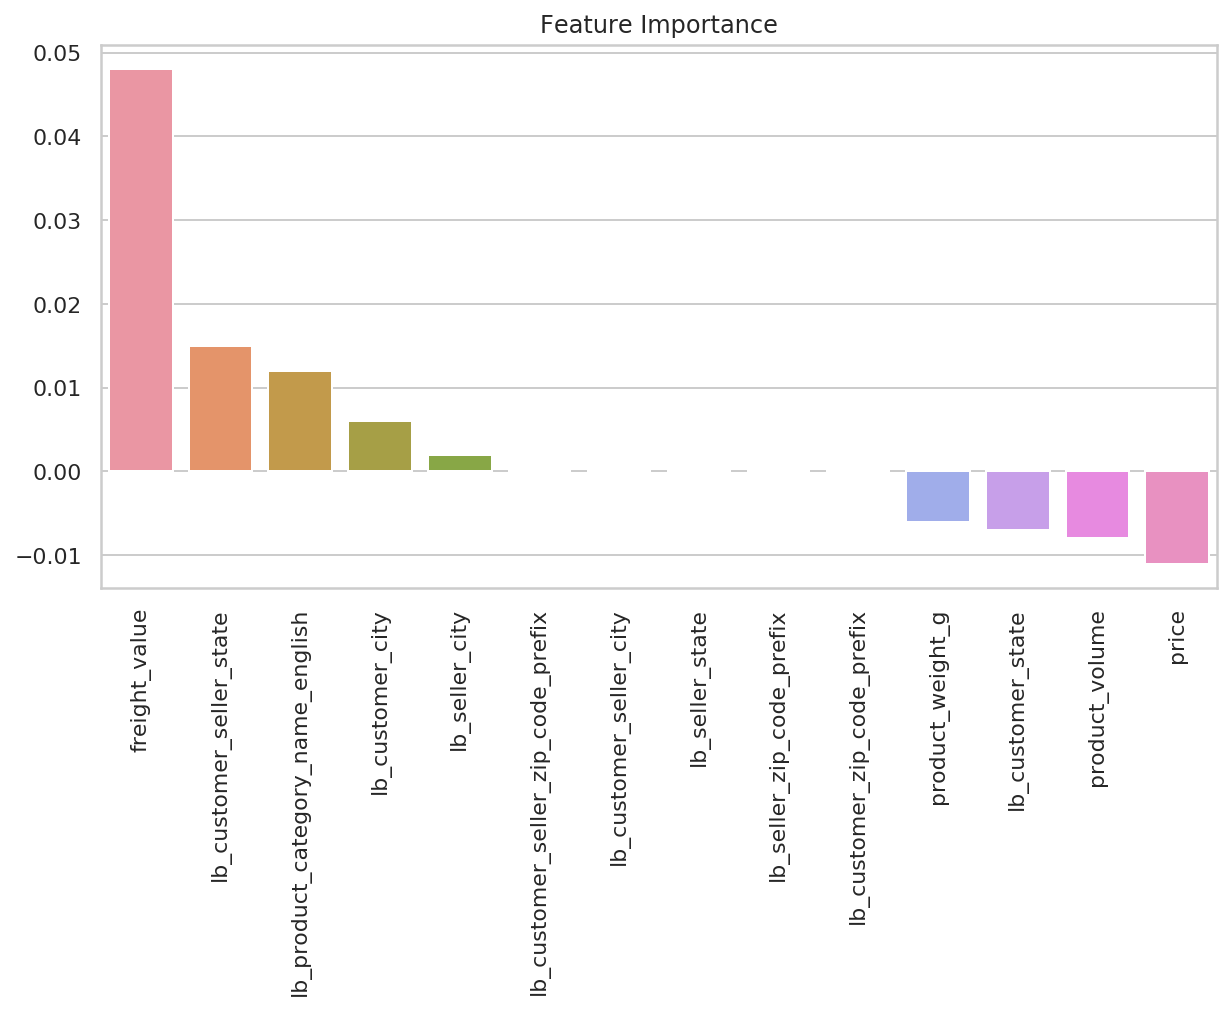

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_importance.index, y = fea_importance.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()